In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bids
!pip install git+https://github.com/npnl/bidsio
import bidsio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 38.1 MB/s 
     |████████████████████████████████| 1.3 MB 75.5 MB/s 
     |████████████████████████████████| 125 kB 69.0 MB/s 
     |████████████████████████████████| 68 kB 7.1 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=0b0c11bb8d143d2241f7b9a43771b766ade3bc0ec65e5d05f770a573385f5c43
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.45
    Uninstalling SQLAlchemy-1.4.45:
      Successfully uninstalled SQLAlchemy-1.4.45
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: p

In [ ]:
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=5,
                                root_dir='/content/drive/MyDrive/split1/train/')

In [ ]:
tmp = bids_loader.load_sample(0)
print(f'There are {len(bids_loader)} subjects in our dataset.')
print(f'Every sample loads {len(tmp)} images.')
print(f'Images have these dimensions: {bids_loader.data_shape}')
print(f'Every batch will load {bids_loader.batch_size} samples.')

There are 525 subjects in our dataset.
Every sample loads 2 images.
Images have these dimensions: (197, 233, 189)
Every batch will load 5 samples.


# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, width_multiplier=1, trilinear=True, use_ds_conv=False):
        """A simple 3D Unet, adapted from a 2D Unet from https://github.com/milesial/Pytorch-UNet/tree/master/unet
        Arguments:
          n_channels = number of input channels; 3 for RGB, 1 for grayscale input
          n_classes = number of output channels/classes
          width_multiplier = how much 'wider' your UNet should be compared with a standard UNet
                  default is 1;, meaning 32 -> 64 -> 128 -> 256 -> 512 -> 256 -> 128 -> 64 -> 32
                  higher values increase the number of kernels pay layer, by that factor
          trilinear = use trilinear interpolation to upsample; if false, 3D convtranspose layers will be used instead
          use_ds_conv = if True, we use depthwise-separable convolutional layers. in my experience, this is of little help. This
                  appears to be because with 3D data, the vast vast majority of GPU RAM is the input data/labels, not the params, so little
                  VRAM is saved by using ds_conv, and yet performance suffers."""
        super(UNet, self).__init__()
        _channels = (32, 64, 128, 256, 512)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = [int(c*width_multiplier) for c in _channels]
        self.trilinear = trilinear
        self.convtype = DepthwiseSeparableConv3d if use_ds_conv else nn.Conv3d

        self.inc = DoubleConv(n_channels, self.channels[0], conv_type=self.convtype)
        self.down1 = Down(self.channels[0], self.channels[1], conv_type=self.convtype)
        self.down2 = Down(self.channels[1], self.channels[2], conv_type=self.convtype)
        self.down3 = Down(self.channels[2], self.channels[3], conv_type=self.convtype)
        factor = 2 if trilinear else 1
        self.down4 = Down(self.channels[3], self.channels[4] // factor, conv_type=self.convtype)
        self.up1 = Up(self.channels[4], self.channels[3] // factor, trilinear)
        self.up2 = Up(self.channels[3], self.channels[2] // factor, trilinear)
        self.up3 = Up(self.channels[2], self.channels[1] // factor, trilinear)
        self.up4 = Up(self.channels[1], self.channels[0], trilinear)
        self.outc = OutConv(self.channels[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            conv_type(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            conv_type(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, conv_type=conv_type)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, kernels_per_layer=1):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(nin, nin * kernels_per_layer, kernel_size=kernel_size, padding=padding, groups=nin)
        self.pointwise = nn.Conv3d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

model = UNet(n_channels=1, n_classes=1)
#model = model.UNet3D(in_channels=1, out_channels=1, num_groups=1, num_levels=2, f_maps=10)

In [ ]:
model.load_state_dict(torch.load('drive/MyDrive/ATLASSTUFF/model_weights_osu1.pth'))

<All keys matched successfully>

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Loss Functions

In [ ]:
class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)

In [ ]:
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

In [ ]:
class GeneralizedDiceLoss(_AbstractDiceLoss):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf.
    """

    def __init__(self, normalization='sigmoid', epsilon=1e-6):
        super().__init__(weight=None, normalization=normalization)
        self.epsilon = epsilon

    def dice(self, prediction, target, weight):
        assert prediction.size() == target.size(), "'prediction' and 'target' must have the same shape"
        prediction = flatten(prediction) #flatten all dimensions except channel/class
        target = flatten(target)
        target = target.float()

        if prediction.size(0) == 1:
            # for GDL to make sense we need at least 2 channels (see https://arxiv.org/pdf/1707.03237.pdf)
            # put foreground and background voxels in separate channels
            prediction = torch.cat((prediction, 1 - prediction), dim=0)
            target = torch.cat((target, 1 - target), dim=0)
        w_l = target.sum(-1)
        w_l = 1 / (w_l * w_l).clamp(min=self.epsilon)
        w_l.requires_grad = False

        intersect = (prediction * target).sum(-1)
        print(intersect.shape)
        intersect = intersect * w_l

        denominator = (prediction + target).sum(-1)
        print(denominator)
        denominator = (denominator * w_l).clamp(min=self.epsilon)

        return 1 - (2 * (intersect.sum() / denominator.sum()))

In [ ]:
loss_func1 = nn.CrossEntropyLoss()
loss_func2 = GeneralizedDiceLoss()

# Rejection Sampling

In [ ]:
import random
def cubeView(batch, labels, cubeSize, threshold):
  shape = batch.shape
  x_len = shape[2]
  y_len = shape[3]
  z_len = shape[4]
  resultData = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  resultLabel = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  for i in range(shape[0]):
    loopB = True
    while(loopB):
      (posx, posy, posz) = random.randint(0, x_len - cubeSize), random.randint(0, y_len - cubeSize), random.randint(0, z_len - cubeSize)
      if (torch.sum(labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]) / torch.sum(labels[i,::,::,::,::]) > threshold):
        resultData[i, :, :, :, :] = batch[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        resultLabel[i, :, :, :, :] = labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        loopB = False
  return resultData, resultLabel

# Downsize

In [ ]:
def downsize_64(batch):
  num_samples = batch.shape[0]
  (197, 233, 189)
  torch.Size([5, 1, 197, 233, 189])

  scale = 3
  batch = batch[:,:,::scale,::scale,::scale]
  batch = batch[:,:,:64,:64]
  zeros = torch.zeros(num_samples,1,64,64,1)
  batch = torch.cat((zeros, batch), 4)
  return batch

torch.Size([5, 1, 197, 233, 189])


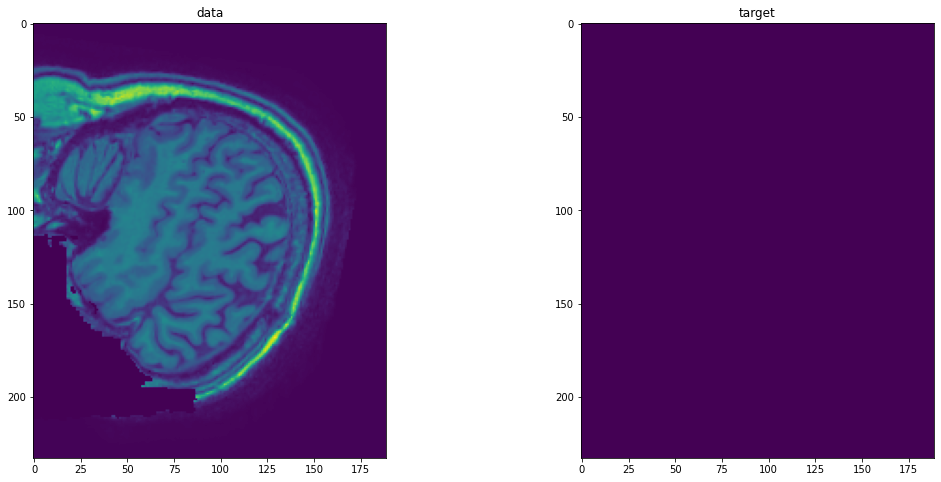

In [ ]:
import matplotlib.pyplot as plt

data, target = next(bids_loader.load_batches())
data = torch.Tensor(data)
target = torch.Tensor(target)

plt.figure(figsize=(18, 8)) 
plt.subplot(121)
plt.imshow(downsize_64(data)[0,0,50]);plt.title('data')
plt.subplot(122)
plt.imshow(downsize_64(target)[0,0,50]);plt.title('target')
print(downsize_64(target).shape)

In [ ]:
import numpy as np
#torch.Size([2, 1, 197, 233, 189])
torch.Size([2, 1, 197, 233, 189])

#xrt = F.pad(data, 2,1,4,3,6,5, "constant", 0)

torch.Size([2, 1, 197, 233, 189])

# Training

In [ ]:
import matplotlib.pyplot as plt

# model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
model.to(device)

#print(data.dtype)
losses = []
dice = []

for epoch in range(20):
    running_loss = 0.0
    i = 0
    for data, label in bids_loader.load_batches():

        #data = np.pad(data, )

        data = torch.Tensor(data)
        label = torch.Tensor(label)

        #data= F.pad(torch.Tensor(data), (2,1,4,3,6,5), "constant", 0)
        #label = F.pad(torch.Tensor(label), (2,1,4,3,6,5), "constant", 0)

        #print(data.shape)
        #print(label.shape)

        data, label = cubeView(data, label, 64, .2)

        #print(data.shape)

        data = data.to(device)
        label = label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        #N, C, H, W = 5, 64, 64, 64
        #data = torch.arange(N*C*H*W).view(N, 1, C, H, W).float()
        #label = torch.arange(N*C*H*W).view(N, 1, C, H, W).float()

        # forward + backward + optimize
        outputs = model(data)
        loss1 = loss_func1(outputs, label)
        loss2 = loss_func2(outputs, label)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % 10 == 9):
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.8f}')
          losses.append(running_loss)
          dice.append(DiceLoss(outputs, label))
          running_loss = 0.0
        i += 1


torch.Size([2])
tensor([ 216628.2500, 2404811.7500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 179305.0781, 2442135.0000], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([  85301.2422, 2536138.7500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 155906.3750, 2465533.5000], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 122407.6406, 2499032.2500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([  73473.7031, 2547966.2500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 123804.5703, 2497635.2500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 198706.1250, 2422733.7500], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([ 196072.5625, 2425367.5000], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([2])
tensor([  79538.2500, 2541901.7500], device='cuda:0', grad_fn=<SumBackward1>)
[1,    10] loss: 0.27473418
torch.Size([2])
tensor([ 117268.

# Loss graph

[2.747341811656952, 1.9313753247261047, 0.17923080921173096, 0.2608782649040222, 0.5239707827568054, 0.966687798500061, 1.204563319683075, 1.1158410906791687, 1.8623708486557007, 1.1933154463768005, 0.865020215511322, 1.4282209873199463, 0.08019280433654785, 0.13842862844467163, 0.4790540337562561, 0.7480735778808594, 0.9096292853355408, 0.8032044172286987, 1.2863621711730957, 0.8476402759552002, 0.5076740384101868, 0.8831760287284851, 0.0735672116279602, 0.0735926628112793, 0.3724386692047119, 0.6169419288635254, 0.6223207712173462, 0.7652062177658081, 1.1751447916030884, 0.617831826210022, 0.4258468747138977, 0.7408108115196228, 0.08087277412414551, 0.11758357286453247, 0.3433244228363037, 0.3866233229637146, 0.4660419225692749, 0.6321139335632324, 1.1780593991279602, 0.6114393472671509, 0.43255704641342163, 0.6919282674789429, 0.05771356821060181, 0.050685107707977295, 0.18587201833724976, 0.5025222897529602, 0.49461275339126587, 0.6581062078475952, 1.1665268540382385, 0.67512899637

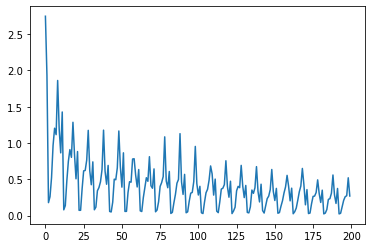

In [ ]:
print(losses)
plt.plot(losses)

# Training Set Output

In [ ]:
device = torch.device('cuda:0')
data, label = next(bids_loader.load_batches())

data = torch.Tensor(data)
label = torch.Tensor(label)

#data = downsize_64(data)
#label = downsize_64(label)
data, label = cubeView(data, label, 64, .6)

data = data.to(device)
label = label.to(device)

model.eval()

# only the deep learning part
with torch.no_grad():
  output = model(data)
print('Network output shape:', output.shape)

Network output shape: torch.Size([5, 1, 64, 64, 64])


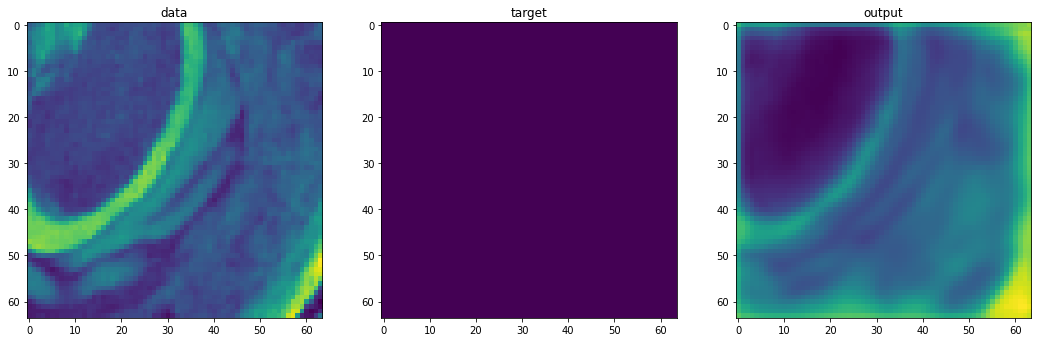

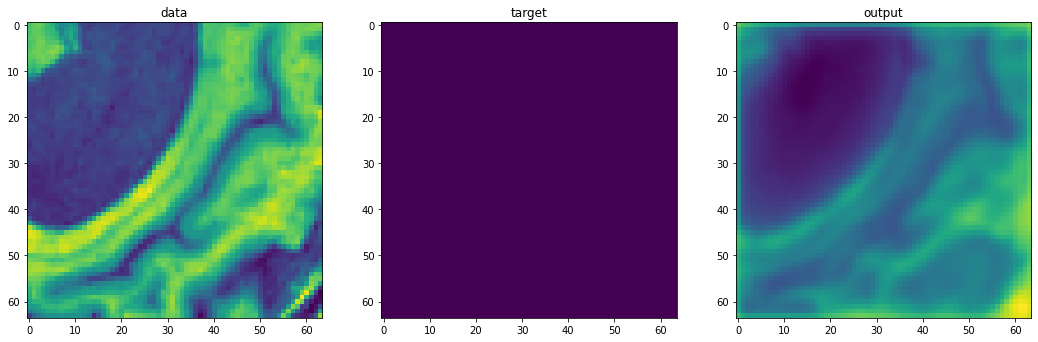

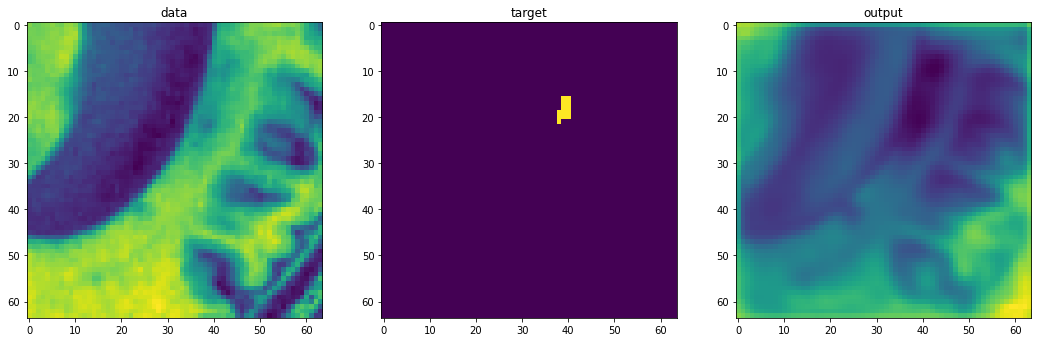

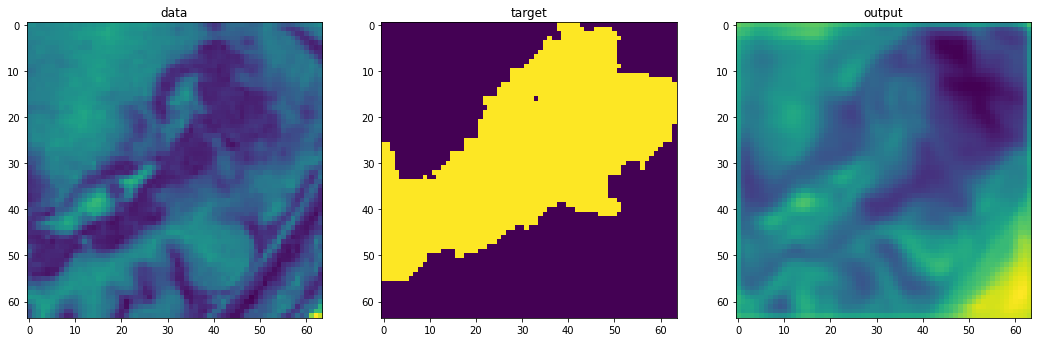

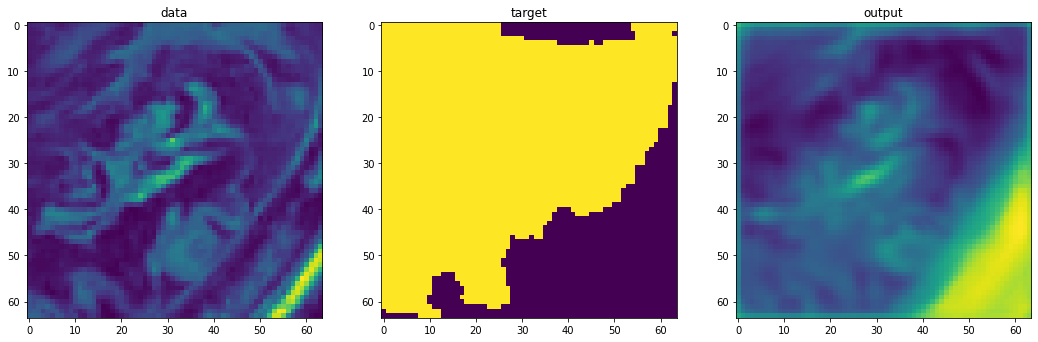

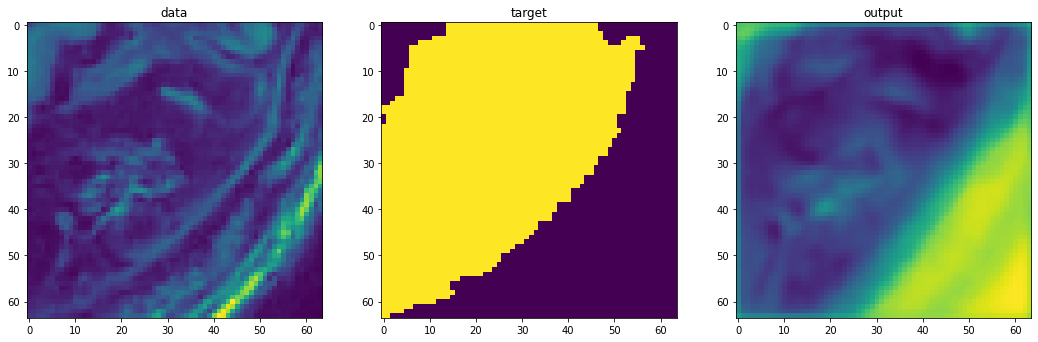

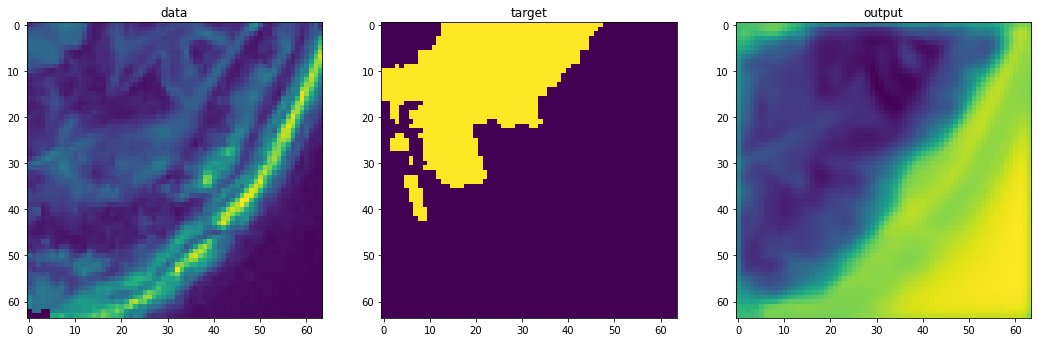

In [ ]:
data = data.cpu()
label = label.cpu()
output = output.cpu()


for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,i]);plt.title('output')

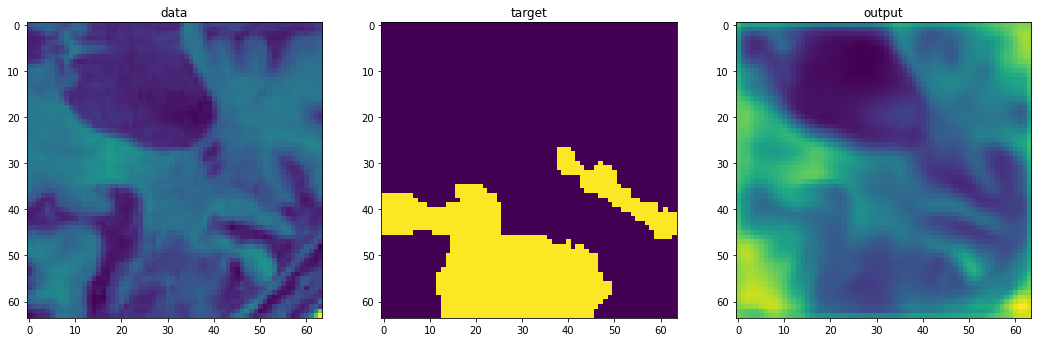

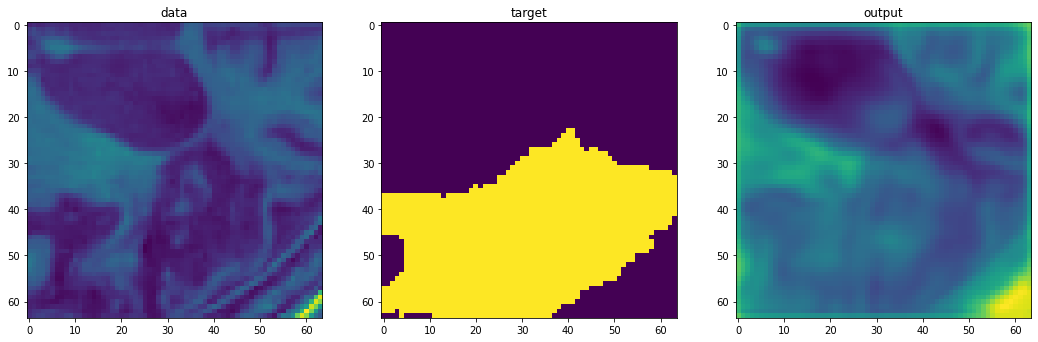

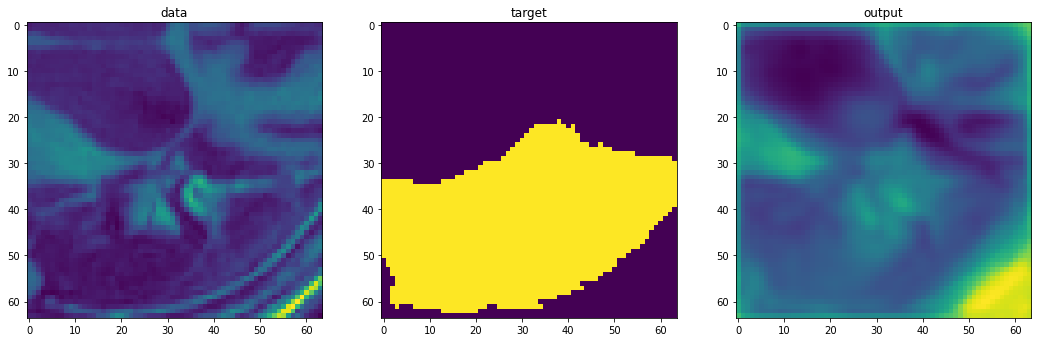

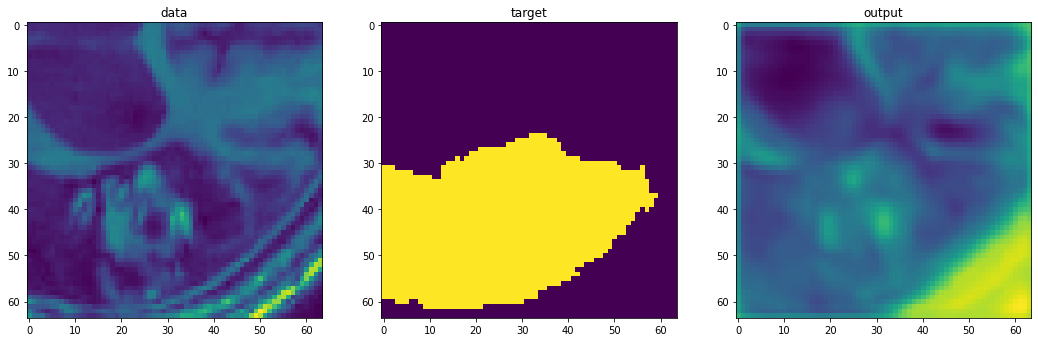

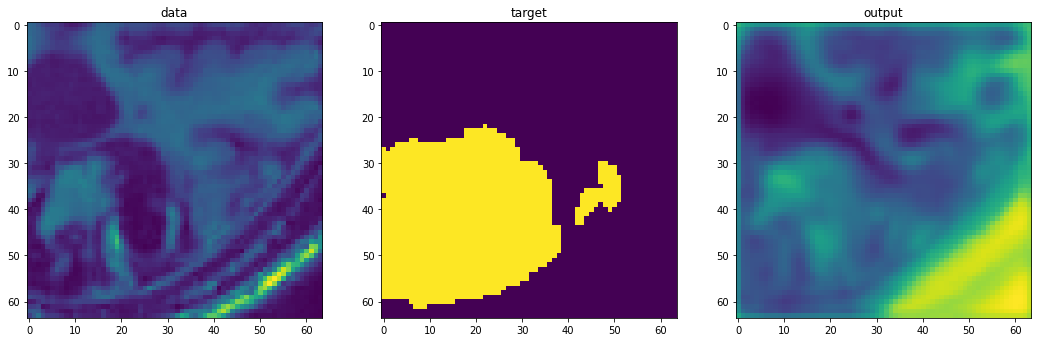

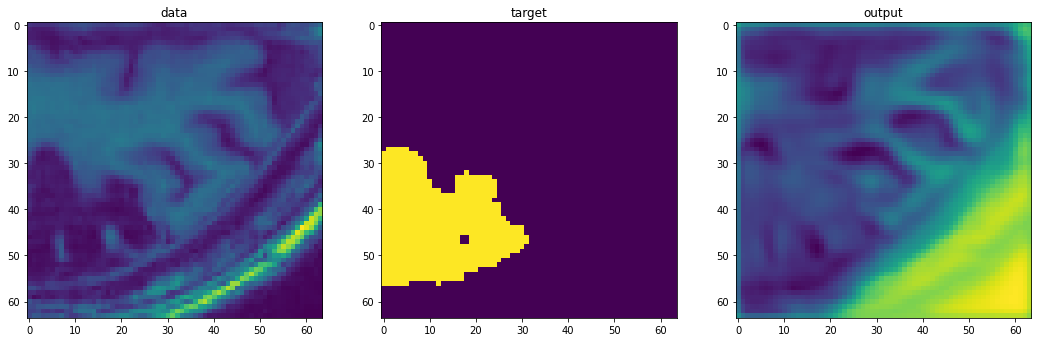

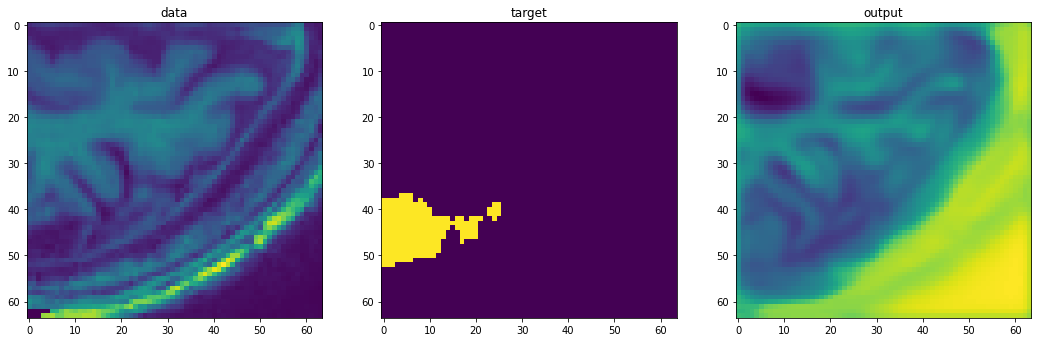

In [ ]:
for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,i]);plt.title('output')

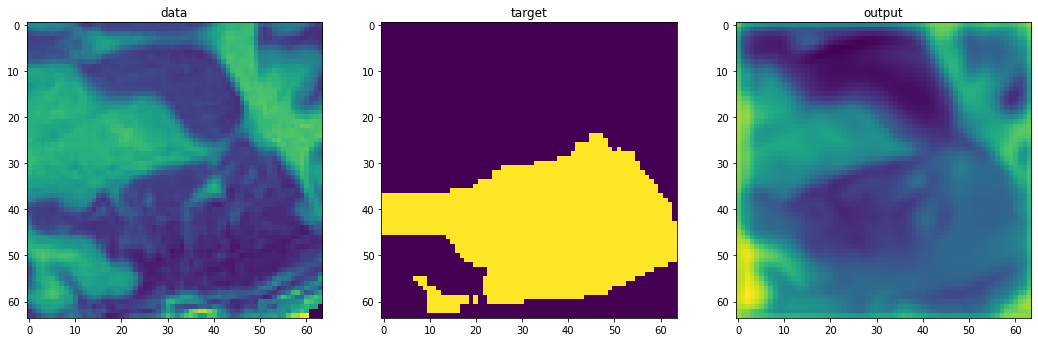

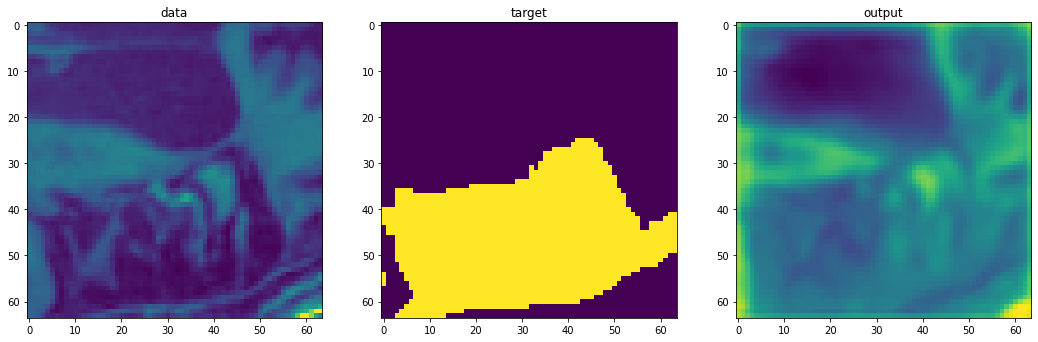

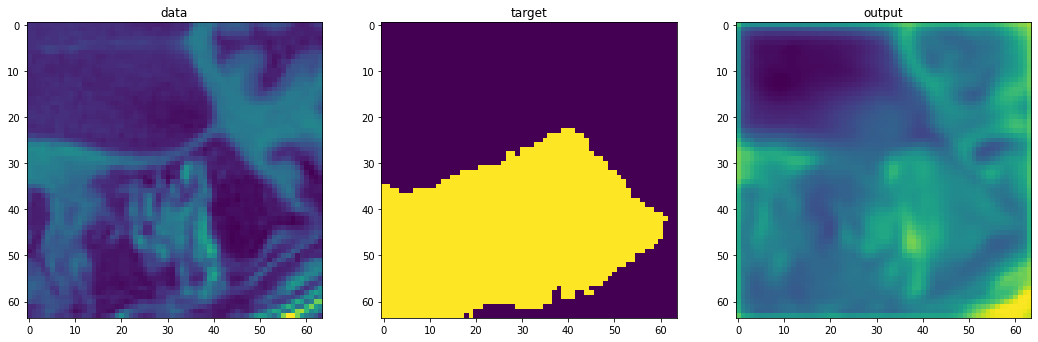

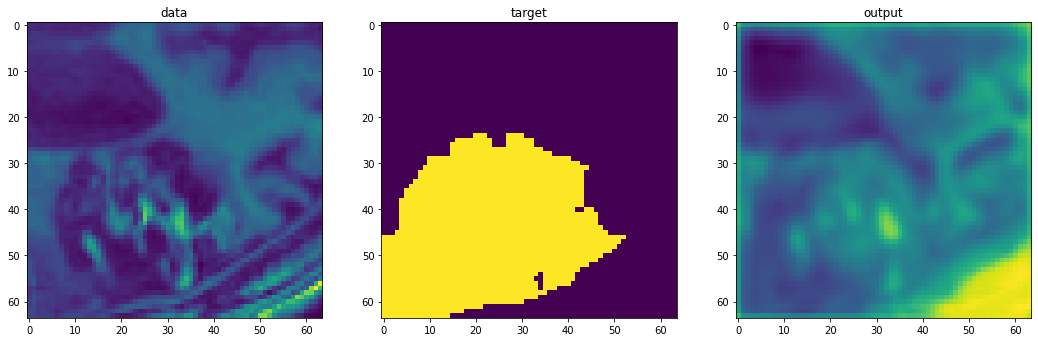

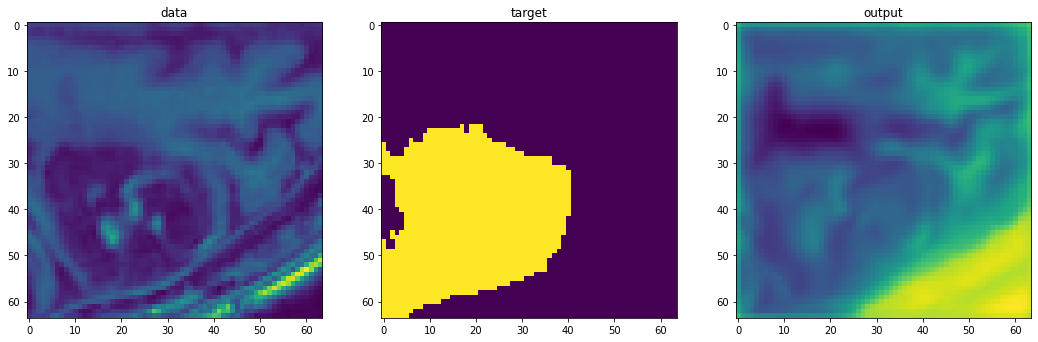

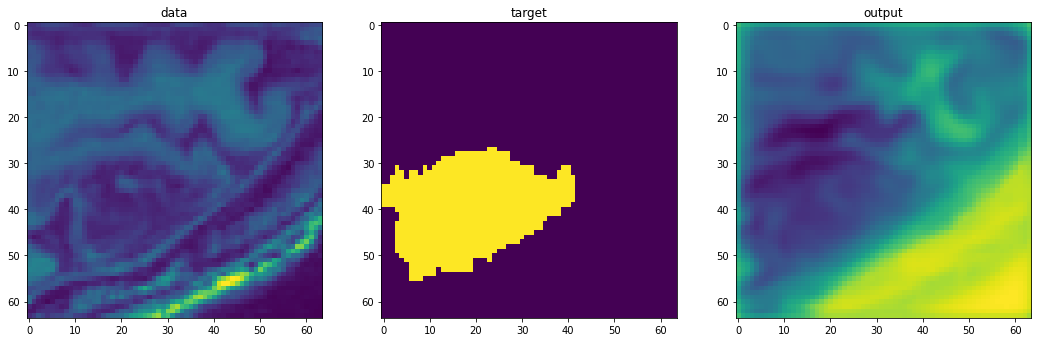

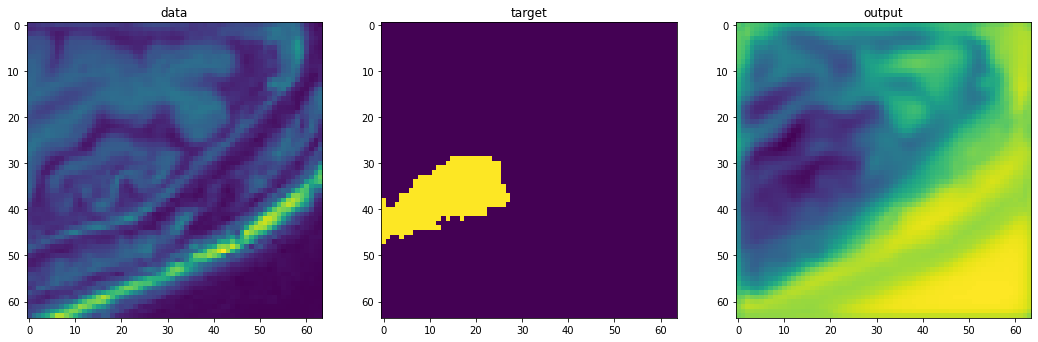

In [ ]:
for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,:,i]);plt.title('output')

# Loading Test Set

In [ ]:
test_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=1,
                                root_dir='drive/MyDrive/split1/test/')

model.eval()

x = 0


# Testing Set Loss

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
model.to(device)

list1 = []
count = 0
for data, label in test_loader.load_batches():
        data = torch.Tensor(data)
       # print(data.shape)
        label = torch.Tensor(label)
       # print(label.shape)

        data = downsize_64(data).to(device)
        label = downsize_64(label).to(device)

       # data, label = cubeView(data, label, 64, .2)

        outputs = model(data)
        loss3 = loss_func3(outputs, label)
        loss4 = loss_func4(outputs, label)
        loss = loss3 + loss4

        # print statistics
        test_loss = loss.item()
       # loss_str1 = f'[{x + 1:5d}] loss: {test_loss :.8f}'
        loss_str = test_loss
       # print(loss_str1)
        print(loss_str)
        list1.append(loss_str)
        count += 1
  

torch.Size([2])
tensor([145964.5312, 378323.4688], device='cuda:0', grad_fn=<SumBackward1>)
0.0009126663208007812
torch.Size([2])
tensor([148423.8594, 375864.1250], device='cuda:0', grad_fn=<SumBackward1>)
0.0018503665924072266
torch.Size([2])
tensor([146605.7500, 377682.2500], device='cuda:0', grad_fn=<SumBackward1>)
0.0018158555030822754
torch.Size([2])
tensor([146174.5938, 378113.4062], device='cuda:0', grad_fn=<SumBackward1>)
1.6629695892333984e-05
torch.Size([2])
tensor([146400.1875, 377887.8125], device='cuda:0', grad_fn=<SumBackward1>)
0.0002961158752441406
torch.Size([2])
tensor([147741.5312, 376546.4375], device='cuda:0', grad_fn=<SumBackward1>)
0.0001055598258972168
torch.Size([2])
tensor([149671.5625, 374616.4375], device='cuda:0', grad_fn=<SumBackward1>)
0.009455978870391846
torch.Size([2])
tensor([148111.8750, 376176.1250], device='cuda:0', grad_fn=<SumBackward1>)
0.0019878745079040527
torch.Size([2])
tensor([147746.2812, 376541.7188], device='cuda:0', grad_fn=<SumBackward

# Testing Set Loss Avg

In [ ]:
print(list1)
list2 = []
for i in list1:
  n = float(i)
  list2.append(n)
print(list2)
print('Avg loss on test set is:', sum(list2)/count)


[0.0009126663208007812, 0.0018503665924072266, 0.0018158555030822754, 1.6629695892333984e-05, 0.0002961158752441406, 0.0001055598258972168, 0.009455978870391846, 0.0019878745079040527, 0.010348200798034668, 0.009595036506652832, 0.007810831069946289, 0.04789608716964722, 0.04003477096557617, 0.012569963932037354, 0.002178013324737549, 0.09060227870941162, 0.004622697830200195, 0.01874232292175293, 0.01688361167907715, 0.03266561031341553, 0.04285246133804321, 2.390146255493164e-05, 6.204843521118164e-05, 0.0056688785552978516, 0.0634622573852539, 0.003668487071990967, 0.001546323299407959, 0.0005904436111450195, 0.00012165307998657227, 0.01930558681488037, 8.58306884765625e-06, 0.002841949462890625, 0.0007777214050292969, 4.035234451293945e-05, 0.003982603549957275, 0.00039714574813842773, 0.0001461505889892578, 0.00019806623458862305, 0.00028520822525024414, 0.000452578067779541, 0.0007402300834655762, 5.823373794555664e-05, 0.002534925937652588, 0.0012940764427185059, 0.0165078043937

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/ATLASSTUFF/model_weights_osu3.pth')